In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from pandas_ml import ConfusionMatrix

# 04 - Applied ML
## Question 1: Propensity score matching
### 0. Loading the dataset




In [2]:
lalonde_df = pd.read_csv('./lalonde.csv')
lalonde_df.head()


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1. A naive analysis

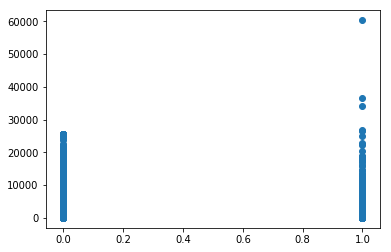

In [3]:
plt.scatter(lalonde_df.treat, lalonde_df.re78)

In [4]:
treated_df = lalonde_df[lalonde_df.treat == 1]
control_df = lalonde_df[lalonde_df.treat == 0]

print("Correlation:", lalonde_df.treat.corr(lalonde_df.re78))

pd.DataFrame(dict(treated = treated_df.re78.describe(), 
                  non_treated=control_df.re78.describe()))


Correlation: -0.0390327053015


,non_treated,treated
count,429.000000,185.000000
mean,6984.169742,6349.143530
std,7294.161791,7867.402218
min,0.000000,0.000000
25%,220.181300,485.229800
50%,4975.505000,4232.309000
75%,11688.820000,9642.999000
max,25564.670000,60307.930000


Naive interpretation :  
The treatment seems to have no effect to the outcome

### 2. A closer look at the data

In [6]:
treated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [7]:
control_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


Treated group contains more "black" people (84%) than the the control group (only 20%).  
Moreover, the treated people were earn less money before the treatment 1974-1975 than the control people.
Furthermore, the ratio of married people in the treated group is less than the control group (19% against 51%).
Despite of having more or less the same years of education, the treated group has more no degree than the control one.  

**It seems that the two groups dont come from the same distribution.**

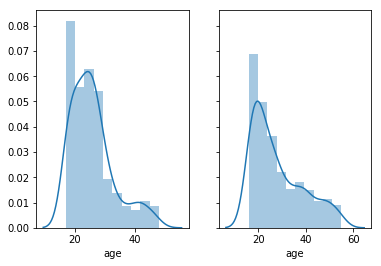

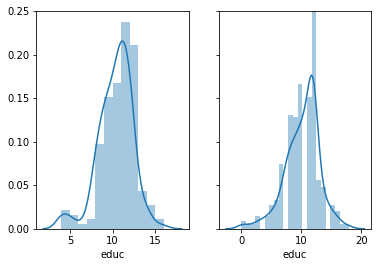

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(treated_df.age, ax=ax1)
sns.distplot(control_df.age, ax=ax2)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(treated_df.educ, ax=ax1)
sns.distplot(control_df.educ, ax=ax2)

As the two groups dont come frome the same distribution, the naive interpretation is not acceptable.

### 3. A propensity score model

In [11]:
from sklearn import linear_model

logistic= linear_model.LogisticRegression()

y = lalonde_df.treat
x = lalonde_df.drop(['treat', 'id', 're78'], axis=1)

logistic.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
proba = logistic.predict_proba(x)
propensity_score = proba[:, 1]

propensity_score_series = pd.Series(propensity_score)
propensity_df = lalonde_df.assign(propensity_score=propensity_score_series.values)
propensity_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


# Q2 : Applied Machine Learning


## 2.1 Preparing Dataset

### Downloading and loading the data into notebook

In [2]:
data_all = fetch_20newsgroups(subset='all')
labels_all = data_all.target

### Vectorizing the text using TF-IDF features and default Scikit-learn functionalities

In [23]:
vectorizer = TfidfVectorizer()
vectors_all = vectorizer.fit_transform(data_all.data)
print('Dataset has ', vectors_all.shape[0] , ' examples with each examples having ', vectors_all.shape[1] , ' dimensions.')

Dataset has  18846  examples with each examples having  173762  dimensions.


## 2.2 Cross Validation bench for finding the optimal parameter

This whole section needs to be run just once for finding the optimal params for andom Forest Classfier. Once found, we can directly jump to the next - Final model section.

### Preparing the data splits

The training data set is 10% of the complete data where the total cross validation data is 90%. We have used scikit learn functionality for this but the same can also be achieved with few more lines of code by joining the labels with data, slicing using pandas/numpy and separating the labels afterwards.

As for cross-validation , we train each model thrice on a randomly chosen subset of the cross-val data. Notice that we have chosen the test_size as 0.11 in Shuffle split ( although called test_size this is the size of the cross_val dataset) because it ~115 of the 90% of the total data. Thus totalling to 9.9%~10% of the whole data. Otherwise, we would've got 9% of the actual data.

In [7]:
vectors_cv, vector_test,labels_cv, labels_test = train_test_split( vectors_all, labels_all, test_size=0.1, random_state=42)
cv = ShuffleSplit(n_splits=3, test_size=0.11, random_state=0)

### 2.2.1 Starting Cross-Validation

Starting with a wide inital guess of params

In [31]:
param_grid = {'max_depth': [20 ,30, 40, 50, 60, 70],
              'n_estimators': [5, 10, 15, 20, 30, 40, 50], }

The `%time` magical commad allows to track the actual time taken to complete. `n_jobs` is an additional parameter 
to specify the number of cores to use to compute. Can be adjused as per user. 

In [32]:
clf =  GridSearchCV(RandomForestClassifier(random_state=0 , n_jobs = 8), param_grid , cv = cv)
%time clf.fit(vectors_cv, labels_cv)

Wall time: 14min 4s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 30, 40, 50], 'max_depth': [20, 30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Obtaining a clean table for performance measures. 

In [33]:
results = pd.DataFrame(clf.cv_results_)

In [34]:
results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.485441,0.165653,0.411707,0.487574,20,5,"{'n_estimators': 5, 'max_depth': 20}",42,0.424278,0.494824,0.426635,0.495545,0.384207,0.472353,0.081700,0.006569,0.019469,0.010767
1,2.117120,0.156975,0.509134,0.625590,20,10,"{'n_estimators': 10, 'max_depth': 20}",39,0.503241,0.623755,0.532115,0.634762,0.492045,0.618252,0.125276,0.010700,0.016881,0.006864
2,2.245847,0.151944,0.574150,0.701083,20,15,"{'n_estimators': 15, 'max_depth': 20}",35,0.575722,0.700865,0.591632,0.705516,0.555097,0.696868,0.084782,0.008742,0.014957,0.003534
3,2.826435,0.149638,0.624435,0.751114,20,20,"{'n_estimators': 20, 'max_depth': 20}",32,0.629935,0.754782,0.635828,0.751310,0.607543,0.747248,0.061035,0.012219,0.012185,0.003079
4,3.272358,0.140097,0.675309,0.806560,20,30,"{'n_estimators': 30, 'max_depth': 20}",26,0.674131,0.797956,0.676488,0.810273,0.675309,0.811452,0.071779,0.001413,0.000962,0.006103
5,4.004456,0.204342,0.709094,0.833923,20,40,"{'n_estimators': 40, 'max_depth': 20}",20,0.705952,0.829468,0.715380,0.839557,0.705952,0.832744,0.294505,0.049824,0.004445,0.004202
6,4.567097,0.241132,0.725594,0.850585,20,50,"{'n_estimators': 50, 'max_depth': 20}",19,0.723630,0.844864,0.723041,0.854232,0.730112,0.852660,0.138987,0.003589,0.003204,0.004096
7,1.885443,0.161891,0.465527,0.603249,30,5,"{'n_estimators': 5, 'max_depth': 30}",41,0.469063,0.609342,0.467885,0.599515,0.459635,0.600891,0.044893,0.004418,0.004194,0.004345
8,2.853358,0.161247,0.576704,0.747773,30,10,"{'n_estimators': 10, 'max_depth': 30}",34,0.577490,0.746004,0.578079,0.749017,0.574543,0.748297,0.065387,0.009129,0.001547,0.001285
9,2.993183,0.137166,0.641917,0.814968,30,15,"{'n_estimators': 15, 'max_depth': 30}",30,0.626400,0.811386,0.654685,0.812959,0.644667,0.820558,0.172783,0.002748,0.011710,0.004005


## 2.2.2 Observation for further experiment

We notice that in the above experiment the best results are obtained for the highest value of parameters thus suggesting to try even higher values. Using a higher but narrower range this time. 


In [38]:
param_grid2= {'max_depth': [60, 70, 80,90,100],
              'n_estimators': [40, 50, 60,70,80,90]}
clf2 = GridSearchCV(RandomForestClassifier(random_state=0 , n_jobs = 8), param_grid2 , cv = cv)
%time clf2.fit(vectors_cv, labels_cv)

Wall time: 32min 38s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [40, 50, 60, 70, 80, 90], 'max_depth': [60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
results2 = pd.DataFrame(clf2.cv_results_)

In [40]:
results2

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,10.025961,0.213422,0.792575,0.984954,60,40,"{'n_estimators': 40, 'max_depth': 60}",30,0.802004,0.986832,0.786093,0.982835,0.789629,0.985194,0.599586,0.065213,0.006821,0.001640
1,11.211836,0.281760,0.804164,0.987552,60,50,"{'n_estimators': 50, 'max_depth': 60}",27,0.806718,0.988994,0.799057,0.985718,0.806718,0.987945,0.268820,0.070085,0.003611,0.001366
2,13.134366,0.379295,0.812610,0.988753,60,60,"{'n_estimators': 60, 'max_depth': 60}",21,0.814378,0.988994,0.809664,0.987618,0.813789,0.989649,0.494110,0.003539,0.002097,0.000846
3,15.383046,0.319809,0.819093,0.989780,60,70,"{'n_estimators': 70, 'max_depth': 60}",18,0.823217,0.990304,0.817914,0.988863,0.816146,0.990173,0.506953,0.063684,0.003005,0.000651
4,17.452258,0.319094,0.826164,0.990719,60,80,"{'n_estimators': 80, 'max_depth': 60}",14,0.827932,0.990632,0.822039,0.990042,0.828521,0.991483,0.430513,0.059957,0.002927,0.000592
5,17.555641,0.315719,0.831664,0.991549,60,90,"{'n_estimators': 90, 'max_depth': 60}",9,0.836181,0.992204,0.824985,0.990501,0.833824,0.991942,0.572023,0.053112,0.004819,0.000749
6,11.490247,0.200874,0.797682,0.992444,70,40,"{'n_estimators': 40, 'max_depth': 70}",28,0.789629,0.993449,0.797879,0.992859,0.805539,0.991025,0.057396,0.053809,0.006497,0.001032
7,13.546562,0.249444,0.807307,0.993470,70,50,"{'n_estimators': 50, 'max_depth': 70}",24,0.800236,0.994693,0.806718,0.993776,0.814968,0.991942,0.243048,0.022790,0.006029,0.001144
8,17.747160,0.345111,0.818503,0.994082,70,60,"{'n_estimators': 60, 'max_depth': 70}",19,0.813200,0.995086,0.818503,0.994169,0.823807,0.992990,0.877132,0.073292,0.004330,0.000858
9,19.579997,0.281938,0.825378,0.994759,70,70,"{'n_estimators': 70, 'max_depth': 70}",15,0.823217,0.995480,0.825575,0.994824,0.827342,0.993973,1.045243,0.069548,0.001690,0.000617


### 2.2.3 : Even further experiment

The same problem repeats again. Using even higher values but with small range now. 

In [41]:
param_grid3= {'max_depth': [90,100, 110, 120],
              'n_estimators': [80,90, 100 , 110]}
clf3 = GridSearchCV(RandomForestClassifier(random_state=0 , n_jobs = 8), param_grid3 , cv = cv)
%time clf3.fit(vectors_cv, labels_cv)

Wall time: 28min 55s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [80, 90, 100, 110], 'max_depth': [90, 100, 110, 120]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [43]:
results3 = pd.DataFrame(clf3.cv_results_)
results3

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,24.795837,0.411968,0.833039,0.998733,90,80,"{'n_estimators': 80, 'max_depth': 90}",16,0.833235,0.998559,0.826164,0.998755,0.839717,0.998886,0.518043,0.049680,0.005535,1.346177e-04
1,28.082280,0.373256,0.834414,0.998843,90,90,"{'n_estimators': 90, 'max_depth': 90}",14,0.838539,0.998690,0.823807,0.998886,0.840896,0.998952,1.451036,0.141791,0.007562,1.113518e-04
2,30.292976,0.373348,0.836574,0.998843,90,100,"{'n_estimators': 100, 'max_depth': 90}",12,0.836181,0.998886,0.830289,0.998821,0.843253,0.998821,1.037137,0.053993,0.005300,3.088342e-05
3,30.470957,0.402448,0.839128,0.998952,90,110,"{'n_estimators': 110, 'max_depth': 90}",10,0.842074,0.999017,0.830289,0.998886,0.845021,0.998952,0.270371,0.101395,0.006365,5.349165e-05
4,25.376795,0.362958,0.835985,0.999301,100,80,"{'n_estimators': 80, 'max_depth': 100}",13,0.840306,0.999345,0.828521,0.999017,0.839128,0.999541,1.018903,0.107333,0.005300,2.161839e-04
5,28.527824,0.297910,0.843449,0.999345,100,90,"{'n_estimators': 90, 'max_depth': 100}",6,0.845610,0.999214,0.838539,0.999214,0.846199,0.999607,0.643824,0.050777,0.003481,1.853005e-04
6,31.149265,0.459654,0.846003,0.999323,100,100,"{'n_estimators': 100, 'max_depth': 100}",3,0.849735,0.999214,0.839717,0.999148,0.848556,0.999607,0.670212,0.113889,0.004471,2.025161e-04
7,38.339701,0.515438,0.848753,0.999476,100,110,"{'n_estimators': 110, 'max_depth': 100}",2,0.849735,0.999410,0.845610,0.999279,0.850913,0.999738,1.447922,0.129968,0.002274,1.928669e-04
8,30.370284,0.348293,0.834021,0.999716,110,80,"{'n_estimators': 80, 'max_depth': 110}",15,0.828521,0.999672,0.834414,0.999672,0.839128,0.999803,0.400752,0.106480,0.004339,6.176684e-05
9,32.558777,0.388287,0.838342,0.999694,110,90,"{'n_estimators': 90, 'max_depth': 110}",11,0.834414,0.999672,0.837949,0.999672,0.842664,0.999738,1.728720,0.071644,0.003379,3.088342e-05


### 2.2.4 : The final step

the same problem still repeats but since the gap in best estimators is much smaller now, this means this step should 
find the optimal parameters now. 

In [44]:
param_grid4= {'max_depth': [120,  140, 160],
              'n_estimators': [100 ,120, 140]}
clf4 = GridSearchCV(RandomForestClassifier(random_state=0 , n_jobs = 8), param_grid4 , cv = cv)
%time clf4.fit(vectors_cv, labels_cv)

Wall time: 24min 38s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 120, 140], 'max_depth': [120, 140, 160]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [45]:
results4 = pd.DataFrame(clf4.cv_results_)
results4


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,36.849772,0.458792,0.844824,0.999913,120,100,"{'n_estimators': 100, 'max_depth': 120}",9,0.845610,0.999934,0.836771,0.999934,0.852092,0.999869,0.495320,0.178278,0.006279,3.088342e-05
1,43.615133,0.452934,0.849735,0.999869,120,120,"{'n_estimators': 120, 'max_depth': 120}",6,0.855038,0.999869,0.839717,0.999869,0.854449,0.999869,0.231218,0.106040,0.007088,0.000000e+00
2,48.590655,0.535677,0.851306,0.999847,120,140,"{'n_estimators': 140, 'max_depth': 120}",4,0.856806,0.999869,0.843253,0.999803,0.853860,0.999869,0.553527,0.153332,0.005820,3.088342e-05
3,39.536621,0.467547,0.848949,0.999934,140,100,"{'n_estimators': 100, 'max_depth': 140}",7,0.852092,0.999934,0.846788,0.999934,0.847967,0.999934,0.390505,0.025862,0.002274,1.110223e-16
4,51.254158,0.654150,0.851699,0.999934,140,120,"{'n_estimators': 120, 'max_depth': 140}",3,0.857395,0.999934,0.848556,0.999934,0.849146,0.999934,1.298463,0.244252,0.004035,1.110223e-16
5,57.783405,0.574911,0.855431,0.999934,140,140,"{'n_estimators': 140, 'max_depth': 140}",1,0.855628,0.999934,0.853270,0.999934,0.857395,0.999934,1.499260,0.167357,0.001690,1.110223e-16
6,41.718227,0.460633,0.846003,0.999934,160,100,"{'n_estimators': 100, 'max_depth': 160}",8,0.848556,0.999934,0.843253,0.999934,0.846199,0.999934,0.664722,0.061454,0.002170,1.110223e-16
7,56.259005,0.750183,0.850913,0.999934,160,120,"{'n_estimators': 120, 'max_depth': 160}",5,0.852681,0.999934,0.846788,0.999934,0.853270,0.999934,2.127975,0.042717,0.002927,1.110223e-16
8,62.502033,0.593865,0.851896,0.999934,160,140,"{'n_estimators': 140, 'max_depth': 160}",2,0.852681,0.999934,0.845610,0.999934,0.857395,0.999934,4.680417,0.111873,0.004843,1.110223e-16


We observe that now the best performance is found at intermediate values suggesting good paramaters to be found.
We can still optimize the values in smaller range but this is not worth the effort since the change from the peak performance
around the optimal paramater is too slow that suggests that any such optimization is not fruitful for the effort.

## 2.3 : The Final Model

In case the cross validation is perfomed we can load the model directly with `model = clf4.best_estimator_` 
Otherwise, we can train the model using the best parameters in the 2.2

In [10]:
# Noting the best parameter setting to be n_estimators = 140 and max_depth = 140. We can directly train 
# the best model for next time.

model = RandomForestClassifier(n_jobs=8, random_state=0 , n_estimators = 140 , max_depth = 140)

vectors_train, vector_val,labels_train, labels_val = train_test_split(vectors_cv, labels_cv, test_size=0.11, random_state=42)
model.fit(vectors_train,labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=140, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

## 2.4 : Evaluation Criterion : Accuracy and Confusion Matrix

### 2.4.1 : Different Accuracies:

It is interesting to note that even though the validation dataset is not use for training, the accuracy on val is certainly 
consistently a bit higher than the testing dataset which is an artefact of the fact that we are using it to indirectly train by 
choosing the best parameters through it.

In [29]:
print('Training Accuracy', np.round(model.score(vectors_train, labels_train)*100,3))
print('Validation set Accuracy', np.round(model.score(vector_val,labels_val)*100,3))
print('Test Accuracy', np.round(model.score(vector_test,labels_test)*100,3))

Training Accuracy 99.993
Validation set Accuracy 85.423
Test Accuracy 84.297


### 2.4.2 : Confusion Matrix :

We are using the library `pandas-ml` for firectly plotting the confusion matrix. Same can also be achieved in scikit-learn although wit much more lines of code. 

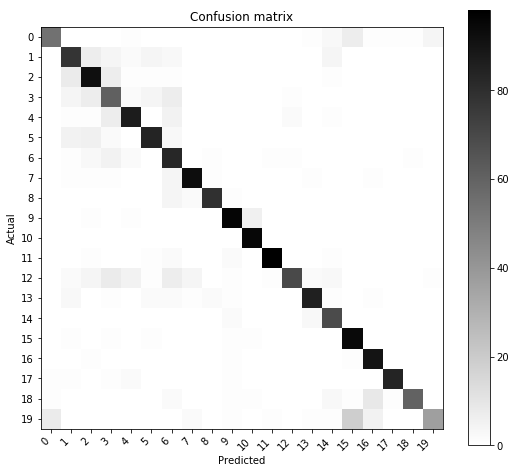

In [31]:
labels_pred =model.predict(vector_test)
cm = ConfusionMatrix(labels_test,labels_pred)
cm.plot()

## 2.5 : Inspecting feature importances : 

In [35]:
print(len(model.feature_importances_))

173762


In [41]:
names = list(data_all.target_names)

In [44]:
print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True))

[(0.00040000000000000002, 'alt.atheism'), (0.00020000000000000001, 'comp.graphics'), (0.0, 'talk.religion.misc'), (0.0, 'talk.politics.misc'), (0.0, 'talk.politics.mideast'), (0.0, 'talk.politics.guns'), (0.0, 'soc.religion.christian'), (0.0, 'sci.space'), (0.0, 'sci.med'), (0.0, 'sci.electronics'), (0.0, 'sci.crypt'), (0.0, 'rec.sport.hockey'), (0.0, 'rec.sport.baseball'), (0.0, 'rec.motorcycles'), (0.0, 'rec.autos'), (0.0, 'misc.forsale'), (0.0, 'comp.windows.x'), (0.0, 'comp.sys.mac.hardware'), (0.0, 'comp.sys.ibm.pc.hardware'), (0.0, 'comp.os.ms-windows.misc')]
